In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install timm
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 89.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 63.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 120.5 MB/s eta 0:00:00


In [3]:
import os
import cv2
import gc
import numpy as np
import pandas as pd
import itertools
from tqdm.autonotebook import tqdm
import albumentations as A
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
import timm
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer

<ipython-input-3-2540d8c9d86b>:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [59]:
class CFG:
    debug = False
    # image_path = image_path
    # captions_path = captions_path
    batch_size = 32
    num_workers = 2
    head_lr = 1e-3
    image_encoder_lr = 1e-4
    text_encoder_lr = 1e-5
    weight_decay = 1e-3
    patience = 1
    factor = 0.8
    epochs = 1
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model_name = 'vit_base_patch32_clip_224.openai'
    image_embedding = 768
    text_encoder_model = "distilbert-base-uncased"
    text_embedding = 768
    text_tokenizer = "distilbert-base-uncased"
    max_length = 200

    pretrained = True # for both image encoder and text encoder
    trainable = True # for both image encoder and text encoder
    temperature = 1.0

    # image size
    size = 224

    # for projection head; used for both image and text encoders
    num_projection_layers = 1
    projection_dim = 512 
    dropout = 0.1

In [5]:
class CLIPDataset(torch.utils.data.Dataset):
    def __init__(self, image_filenames, captions, tokenizer, transforms):
        """
        image_filenames and cpations must have the same length; so, if there are
        multiple captions for each image, the image_filenames must have repetitive
        file names 
        """

        self.image_filenames = image_filenames
        self.captions = captions
        self.encoded_captions = tokenizer(
            captions, padding=True, truncation=True, max_length=CFG.max_length
        )

        self.transforms = transforms

    def __getitem__(self, idx):

        item = {
            key: torch.tensor(values[idx])
            for key, values in self.encoded_captions.items()
        }


        image = cv2.imread(f"{CFG.image_path}/{self.image_filenames[idx]}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transforms(image=image)['image']

        item['image'] = torch.tensor(image).permute(2, 0, 1).float()
        item['productDisplayName'] = self.captions[idx]

        return item


    def __len__(self):
        return len(self.captions)



def get_transforms(mode="train"):
    if mode == "train":
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )
    else:
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )

In [6]:
class ImageEncoder(nn.Module):
    """
    Encode images to a fixed size vector
    """

    def __init__(
        self, model_name=CFG.model_name, pretrained=CFG.pretrained, trainable=CFG.trainable
    ):
        super().__init__()
        self.model = timm.create_model(
            model_name, pretrained, num_classes=0, global_pool="avg"
        )
        for p in self.model.parameters():
            p.requires_grad = trainable

    def forward(self, x):
        return self.model(x)

In [7]:
class TextEncoder(nn.Module):
    def __init__(self, model_name=CFG.text_encoder_model, pretrained=CFG.pretrained, trainable=CFG.trainable):
        super().__init__()
        if pretrained:
            self.model = DistilBertModel.from_pretrained(model_name)
        else:
            self.model = DistilBertModel(config=DistilBertConfig())
            
        for p in self.model.parameters():
            p.requires_grad = trainable

        # we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]

In [8]:
class ProjectionHead_img(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=CFG.projection_dim,
        dropout=CFG.dropout
    ):
        super().__init__()
        print("Image emb:",embedding_dim)
        print("Proj dem",projection_dim)
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)
    
    def forward(self, x):
        print(x.shape)
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

class ProjectionHead_txt(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=CFG.projection_dim,
        dropout=CFG.dropout
    ):
        super().__init__()
        print("Text emb:",embedding_dim)
        print("Proj dem",projection_dim)
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)
    
    def forward(self, x):
        print("Input Feature:",x.shape)
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

In [9]:
class CLIPModel(nn.Module):
    def __init__(
        self,
        temperature=CFG.temperature,
        image_embedding=CFG.image_embedding,
        text_embedding=CFG.text_embedding,
    ):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead_img(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead_txt(embedding_dim=text_embedding)
        self.temperature = temperature


    def forward(self, batch):
        # Getting Image and Text Features
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )

        # Getting Image and Text Embeddings (with same dimension)
        print("Features:",image_features.shape,text_features.shape)
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)
        print("Embeddings:",image_embeddings.shape,text_embeddings.shape)
        # Calculating the Loss
        logits = (text_embeddings @ image_embeddings.T) / self.temperature
        images_similarity = image_embeddings @ image_embeddings.T
        texts_similarity = text_embeddings @ text_embeddings.T
        targets = F.softmax(
            (images_similarity + texts_similarity) / (2 * self.temperature), dim=-1
        )
        texts_loss = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
        return loss.mean()

def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

In [10]:
def make_train_valid_dfs():
    dataframe = pd.read_csv(f"{CFG.captions_path}/captions.csv")
    # print(dataframe.head())
    max_id = dataframe["id"].max() + 1 if not CFG.debug else 100
    image_ids = np.arange(0, max_id)
    np.random.seed(42)
    valid_ids = np.random.choice(
        image_ids, size=int(0.2 * len(image_ids)), replace=False
    )
    train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]
    train_dataframe = dataframe[dataframe["id"].isin(train_ids)].reset_index(drop=True)
    valid_dataframe = dataframe[dataframe["id"].isin(valid_ids)].reset_index(drop=True)
    return train_dataframe, valid_dataframe


def build_loaders(dataframe, tokenizer, mode):

    transforms = get_transforms(mode=mode)
    # print(dataframe["productDisplayName"].tolist())
    image_paths = dataframe["image"].astype('str').tolist()
    texts = dataframe["productDisplayName"].astype('str').tolist()
    dataset = CLIPDataset(
        image_paths,
        texts,
        tokenizer=tokenizer,
        transforms=transforms,
    )

    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        shuffle=True if mode == "train" else False,
    )
    return dataloader

In [11]:
def get_image_embeddings(valid_df, model_path):
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")
    
    model = CLIPModel().to(CFG.device)
    model.load_state_dict(torch.load(model_path, map_location=CFG.device))
    model.eval()
    
    valid_image_embeddings = []
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            image_features = model.image_encoder(batch["image"].to(CFG.device))
            image_embeddings = model.image_projection(image_features)
            valid_image_embeddings.append(image_embeddings)
    return model, torch.cat(valid_image_embeddings)

In [ ]:
# _, valid_df = make_train_valid_dfs()
# model, image_embeddings = get_image_embeddings(valid_df, "/content/drive/MyDrive/Saved_Model/CLIP_model_VIT_Fashion.pt")


    



In [ ]:
def find_matches(model, image_embeddings, query, image_filenames, n=9):
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    encoded_query = tokenizer([query])
    batch = {
        key: torch.tensor(values).to(CFG.device)
        for key, values in encoded_query.items()
    }
    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        text_embeddings = model.text_projection(text_features)
    
    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    dot_similarity = text_embeddings_n @ image_embeddings_n.T
    
    values, indices = torch.topk(dot_similarity.squeeze(0), n * 5)
    matches = [image_filenames[idx] for idx in indices[::5]]
    
    _, axes = plt.subplots(3, 3, figsize=(10, 10))
    for match, ax in zip(matches, axes.flatten()):
        image = cv2.imread(f"{CFG.image_path}/{match}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        ax.axis("off")
    
    plt.show()

In [12]:
!pip install -qU datasets transformers sentence-transformers \
                 pinecone-client pinecone-text protobuf==3.20.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.2/177.2 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.7/283.7 kB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [13]:
import os
import pinecone

# initialize connection to pinecone (get API key at app.pinecone.io)
api_key = os.getenv("3c1215ea-8adb-4c61-a39a-e605bf37be57") or "PINECONE_API_KEY"
# find your environment next to the api key in pinecone console
env = os.getenv("asia-southeast1-gcp-free") or "PINECONE_ENVIRONMENT"

# init connection to pinecone
pinecone.init(
    api_key=api_key,
    environment=env
)

In [14]:
# # choose a name for your index
# index_name = "hybrid"

# if index_name not in pinecone.list_indexes():
#     # create the index
#     pinecone.create_index(
#       index_name,
#       dimension=512,
#       metric="dotproduct",
#       pod_type="Starter"
#     )
# pineconeIndex = pinecone.GRPCIndex(index_name)


## Connect with the pine cone
import pinecone
# init connection to pinecone
pinecone.init(
    api_key="3c1215ea-8adb-4c61-a39a-e605bf37be57", # app.pinecone.io
    environment="asia-southeast1-gcp-free" # find next to api key
)

index_name = "hybrid"

if index_name not in pinecone.list_indexes():
# create the index
 pinecone.create_index(
    index_name,
    dimension=512,
    metric="dotproduct",
    pod_type="Starter")

# pineconeIndex = pinecone.GRPCIndex(index_name)


In [15]:
index = pinecone.Index(index_name)

In [65]:
from datasets import load_dataset

# load the dataset from huggingface datasets hub
fashion = load_dataset(
    "ashraq/fashion-product-images-small",
    split="train"
)
fashion

Dataset({
    features: ['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName', 'image'],
    num_rows: 44072
})

In [40]:
# fashion_data=fashion[:2000]

In [68]:
# assign the images and metadata to separate variables
images = fashion["image"]
metadata = fashion.remove_columns("image")

In [69]:
# convert metadata into a pandas dataframe
metadata=metadata
metadata = metadata.to_pandas()
metadata.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [19]:
from pinecone_text.sparse import BM25Encoder

bm25 = BM25Encoder()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# "Turtle Check Men Navy Blue Shirt".lower().split()

In [20]:
bm25.fit(metadata['productDisplayName'])

  0%|          | 0/44072 [00:00<?, ?it/s]

In [ ]:
# metadata['productDisplayName'][0]

In [21]:
bm25.encode_queries(metadata['productDisplayName'][0])

{'indices': [23789636,
  1830646559,
  632192512,
  931643408,
  3905155331,
  3828986392],
 'values': [0.3276687848622804,
  0.19377339510596148,
  0.040475545164610806,
  0.1808640794607714,
  0.10791423980552016,
  0.1493039556008558]}

In [22]:
bm25.encode_documents(metadata['productDisplayName'][0])

{'indices': [23789636,
  1830646559,
  632192512,
  931643408,
  3905155331,
  3828986392],
 'values': [0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887]}

In [23]:
from sentence_transformers import SentenceTransformer
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# load a CLIP model from huggingface
model = SentenceTransformer(
    'sentence-transformers/clip-ViT-B-32',
    device=device
)
model


SentenceTransformer(
  (0): CLIPModel()
)

In [24]:
dense_vec = model.encode([metadata['productDisplayName'][0]])


In [25]:
dense_vec

array([[ 3.47599238e-01,  1.86053246e-01, -3.43704075e-02,
        -8.76949653e-02,  2.12450728e-01, -4.63767529e-01,
        -2.62030393e-01, -2.67075807e-01,  2.11454466e-01,
        -1.45174474e-01, -2.21526474e-01,  7.72616565e-01,
         4.07888144e-01,  1.98981389e-01, -2.40782410e-01,
         1.00482211e-01,  3.12819719e-01,  2.33211994e-01,
         2.81544954e-01,  3.93812060e-01,  1.04463331e-01,
         2.52281763e-02,  2.92443931e-01, -2.01948255e-01,
         1.52713493e-01, -2.10447222e-01,  6.16779029e-02,
        -1.53535306e-01,  6.78100884e-02, -5.04500747e-01,
         2.05991790e-02,  2.61264890e-01,  2.34380007e-01,
        -9.56329107e-02, -3.77705395e-02, -2.17030048e-02,
        -1.11793987e-01,  2.48099625e-01, -1.26485333e-01,
        -1.26278728e-01, -1.43248171e-01, -3.04490834e-01,
        -3.61693799e-01, -1.24217361e-01, -2.30935916e-01,
         1.33257091e-01, -1.69667602e-01, -1.21024296e-01,
         9.53745544e-02,  1.76042289e-01, -2.91511774e-0

In [26]:
len(dense_vec[0])

512

In [27]:
model_path="/content/drive/MyDrive/Saved_Model/CLIP_model_VIT_Fashion_512.pt"

model_finetuned = CLIPModel().to(CFG.device)
model_finetuned.load_state_dict(torch.load(model_path, map_location=CFG.device))
model_finetuned.eval()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Image emb: 768
Proj dem 512
Text emb: 768
Proj dem 512


CLIPModel(
  (image_encoder): ImageEncoder(
    (model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=768, out_features=768, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
   

In [28]:
# meta_batch = metadata.iloc[0:2]
# meta_dict = meta_batch.to_dict(orient="records")
# # concatinate all metadata field except for id and year to form a single string
# meta_batch = [" ".join(x) for x in meta_batch.loc[:, ~meta_batch.columns.isin(['id', 'year'])].values.tolist()]
# # extract image batch
# img_batch = images[0:2]
# # create sparse BM25 vectors
# sparse_embeds = bm25.encode_documents([text for text in meta_batch])
# # create dense vectors
# dense_embeds = model.encode(img_batch).tolist()

In [ ]:
len(dense_embeds)

2

In [ ]:
len(sparse_embeds[0])

2

In [29]:
import pandas as pd
h=fashion[:20]
q=pd.DataFrame(h)

# g=fashion.to_pandas()
# f=h['image']
q=h['image']
q

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80 at 0x7F9545031150>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80 at 0x7F9497443AC0>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=L size=60x80 at 0x7F9497443160>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80 at 0x7F94974434C0>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80 at 0x7F94974435E0>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80 at 0x7F9497443310>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80 at 0x7F9497442FE0>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80 at 0x7F94974437F0>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80 at 0x7F9497443760>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80 at 0x7F94974427D0>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80 at 0x7F9497441E70>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80 at 0x7F9497441F30>,
 <PIL.JpegImagePlu

In [ ]:
fashion.iloc[0:10]

In [ ]:
len(dense_embeds)

2

In [30]:
class CLIPModel(nn.Module):
    def __init__(
        self,
        temperature=CFG.temperature,
        image_embedding=CFG.image_embedding,
        text_embedding=CFG.text_embedding,
    ):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead_img(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead_txt(embedding_dim=text_embedding)
        self.temperature = temperature


    def forward(self, batch):
        # Getting Image and Text Features
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )

        # Getting Image and Text Embeddings (with same dimension)
        print("Features:",image_features.shape,text_features.shape)
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)
        print("Embeddings:",image_embeddings.shape,text_embeddings.shape)
        # Calculating the Loss
        logits = (text_embeddings @ image_embeddings.T) / self.temperature
        images_similarity = image_embeddings @ image_embeddings.T
        texts_similarity = text_embeddings @ text_embeddings.T
        targets = F.softmax(
            (images_similarity + texts_similarity) / (2 * self.temperature), dim=-1
        )
        texts_loss = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
        return loss.mean()

def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

In [ ]:
import pandas as pd
        

from PIL import Image 
import torchvision.transforms as transforms
class CLIP_Img_Dataset(torch.utils.data.Dataset):
    def __init__(self, image_filenames,captions, tokenizer):
        """
        image_filenames and cpations must have the same length; so, if there are
        multiple captions for each image, the image_filenames must have repetitive
        file names 
        """
        self.image_filenames = image_filenames
        self.captions = captions
        self.encoded_captions = tokenizer(
            captions, padding=True, truncation=True, max_length=CFG.max_length
        )
        self.transform = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        

    def __getitem__(self, idx):

        item = {
            key: torch.tensor(values[idx])
            for key, values in self.encoded_captions.items()
        }

        # Convert the bytes to a string
        # image_data = self.image_filenames.decode('latin-1')

        # Create a numpy array from the string data
        # print(self.image_filenames[idx])
        # image_array = np.frombuffer(self.image_filenames[idx])
        # image = cv2.cvtColor(np.array(self.image_filenames[idx]), cv2.COLOR_RGB2BGR)
        # Decode the image array using cv2.imdecode
        # image = cv2.imdecode(self.image_filenames[idx], cv2.IMREAD_COLOR)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # np_image = np.array(self.image_filenames[idx])

        # Convert NumPy array to OpenCV format
        # open_cv_image = cv2.cvtColor(np_image.astype(bytes), cv2.COLOR_RGB2BGR)
        image=self.transform(self.image_filenames[idx].convert("RGB"))

        # item['image'] = torch.tensor(image).permute(2, 0, 1).float()
        item['image'] = torch.tensor(image)
        item['productDisplayName'] = self.captions[idx]

        return item


    def __len__(self):
        return len(self.captions)


# def build_img_loaders(dataframe, tokenizer, mode):

#     transforms = get_transforms(mode=mode)
#     # print(dataframe["productDisplayName"].tolist())
#     image_paths = dataframe["image"].tolist()
#     texts = dataframe["productDisplayName"].astype('str').tolist()
#     dataset = CLIP_Img_Dataset(
#         image_paths,
#         texts,
#         tokenizer=tokenizer,
#         transforms=transforms,
#     )

#     dataloader = torch.utils.data.DataLoader(
#         dataset,
#         batch_size=CFG.batch_size,
#         num_workers=0,
#     )
#     return dataloader



def build_img_loaders(fashion_batch, tokenizer):

    # transforms = get_transforms(mode=mode)
    # print(dataframe["productDisplayName"].tolist())
    image_paths = fashion_batch["image"].tolist()
    texts = [" ".join(x) for x in fashion_batch.loc[:, ~fashion_batch.columns.isin(['id', 'year','image'])].values.tolist()]
    dataset = CLIP_Img_Dataset(
        image_paths,
        texts,
        tokenizer=tokenizer
    )

    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=32,
        num_workers=0
    )
    return dataloader


def encode_img_txt(fashion_batch):
    image_df=fashion_batch['image']
    fashion_batch=pd.DataFrame(fashion_batch)
    txt_batch = [" ".join(x) for x in fashion_batch.loc[:, ~fashion_batch.columns.isin(['id', 'year','image'])].values.tolist()]
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    text_embeddings_list=[]
    for query in txt_batch:
        encoded_query = tokenizer([query])
        batch = {
            key: torch.tensor(values).to(CFG.device)
            for key, values in encoded_query.items()
        }
        with torch.no_grad():
            text_features = model_finetuned.text_encoder(
                input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
            )
        text_embeddings = model_finetuned.text_projection(text_features)
        print(CFG.projection_dim)
        text_embeddings_list.append(text_embeddings)



    valid_loader = build_img_loaders(fashion_batch, tokenizer)
    image_embeddings_list=[]
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            image_features = model_finetuned.image_encoder(batch["image"].to(CFG.device))
            image_embeddings = model_finetuned.image_projection(image_features)
            image_embeddings_list.append(image_embeddings)
    print(CFG.projection_dim)
    return image_embeddings_list,text_embeddings_list

from tqdm.auto import tqdm

batch_size = 200




for i in tqdm(range(0, len(fashion), batch_size)):
    # find end of batch
    i_end = min(i+batch_size, len(fashion))
    # extract metadata batch
    meta_batch = metadata.iloc[i:i_end]
    meta_dict = meta_batch.to_dict(orient="records")
    meta_batch = [" ".join(x) for x in meta_batch.loc[:, ~meta_batch.columns.isin(['id', 'year'])].values.tolist()]


    fashion_batch = fashion[i:i_end]

    dense_embeds_temp,sparse_embeds_temp=encode_img_txt(fashion_batch)

    sparse_embeds = bm25.encode_documents([text for text in meta_batch])
    dense_embeds = np.concatenate([tensor.numpy() for tensor in dense_embeds_temp])
    
    # dense_embeds=[tensor.squeeze().numpy() for tensor in dense_embeds_temp]
    # print(dense_embeds,sparse_embeds)

    # create unique IDs
    ids = [str(x) for x in range(i, i_end)]

    upserts = []
    # loop through the data and create dictionaries for uploading documents to pinecone index
    for _id, sparse, dense, meta in zip(ids, sparse_embeds, dense_embeds, meta_dict):
        upserts.append({
            'id': _id,
            'sparse_values': sparse,
            'values': dense,
            'metadata': meta
        })
    # upload the documents to the new hybrid index
    index.upsert(upserts)

# show index description after uploading the documents
index.describe_index_stats()

# print(encode_img_txt(fashion_batch))

# def get_image_embeddings(valid_df, model_path):
#     tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
#     valid_loader = build_loaders(valid_df, tokenizer, mode="valid")
    
#     model = CLIPModel().to(CFG.device)
#     model.load_state_dict(torch.load(model_path, map_location=CFG.device))
#     model.eval()
    
#     valid_image_embeddings = []
#     with torch.no_grad():
#         for batch in tqdm(valid_loader):
#             image_features = model.image_encoder(batch["image"].to(CFG.device))
#             image_embeddings = model.image_projection(image_features)
#             valid_image_embeddings.append(image_embeddings)
#     return model, torch.cat(valid_image_embeddings)

  0%|          | 0/221 [00:00<?, ?it/s]

Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512


  0%|          | 0/7 [00:00<?, ?it/s]

<ipython-input-70-4b8fe4a47ecf>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['image'] = torch.tensor(image)


torch.Size([32, 768])
torch.Size([32, 768])
torch.Size([32, 768])
torch.Size([32, 768])
torch.Size([32, 768])
torch.Size([32, 768])
torch.Size([8, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Inp

  0%|          | 0/7 [00:00<?, ?it/s]

<ipython-input-70-4b8fe4a47ecf>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['image'] = torch.tensor(image)


torch.Size([32, 768])
torch.Size([32, 768])
torch.Size([32, 768])
torch.Size([32, 768])
torch.Size([32, 768])
torch.Size([32, 768])
torch.Size([8, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Inp

  0%|          | 0/7 [00:00<?, ?it/s]

<ipython-input-70-4b8fe4a47ecf>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['image'] = torch.tensor(image)


torch.Size([32, 768])
torch.Size([32, 768])
torch.Size([32, 768])
torch.Size([32, 768])
torch.Size([32, 768])
torch.Size([32, 768])
torch.Size([8, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Inp

  0%|          | 0/7 [00:00<?, ?it/s]

<ipython-input-70-4b8fe4a47ecf>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['image'] = torch.tensor(image)


torch.Size([32, 768])
torch.Size([32, 768])
torch.Size([32, 768])
torch.Size([32, 768])
torch.Size([32, 768])
torch.Size([32, 768])
torch.Size([8, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Inp

  0%|          | 0/7 [00:00<?, ?it/s]

<ipython-input-70-4b8fe4a47ecf>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['image'] = torch.tensor(image)


torch.Size([32, 768])
torch.Size([32, 768])
torch.Size([32, 768])
torch.Size([32, 768])
torch.Size([32, 768])
torch.Size([32, 768])
torch.Size([8, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Inp

  0%|          | 0/7 [00:00<?, ?it/s]

<ipython-input-70-4b8fe4a47ecf>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['image'] = torch.tensor(image)


torch.Size([32, 768])
torch.Size([32, 768])
torch.Size([32, 768])
torch.Size([32, 768])
torch.Size([32, 768])
torch.Size([32, 768])
torch.Size([8, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Inp

  0%|          | 0/7 [00:00<?, ?it/s]

<ipython-input-70-4b8fe4a47ecf>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['image'] = torch.tensor(image)


torch.Size([32, 768])
torch.Size([32, 768])
torch.Size([32, 768])
torch.Size([32, 768])
torch.Size([32, 768])
torch.Size([32, 768])
torch.Size([8, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Inp

  0%|          | 0/7 [00:00<?, ?it/s]

<ipython-input-70-4b8fe4a47ecf>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['image'] = torch.tensor(image)


torch.Size([32, 768])
torch.Size([32, 768])
torch.Size([32, 768])
torch.Size([32, 768])
torch.Size([32, 768])
torch.Size([32, 768])
torch.Size([8, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Inp

  0%|          | 0/7 [00:00<?, ?it/s]

<ipython-input-70-4b8fe4a47ecf>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['image'] = torch.tensor(image)


torch.Size([32, 768])
torch.Size([32, 768])
torch.Size([32, 768])
torch.Size([32, 768])
torch.Size([32, 768])
torch.Size([32, 768])
torch.Size([8, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Inp

  0%|          | 0/7 [00:00<?, ?it/s]

<ipython-input-70-4b8fe4a47ecf>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['image'] = torch.tensor(image)


torch.Size([32, 768])
torch.Size([32, 768])
torch.Size([32, 768])
torch.Size([32, 768])
torch.Size([32, 768])
torch.Size([32, 768])
torch.Size([8, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Input Feature: torch.Size([1, 768])
512
Inp

In [37]:
dense_embeds

array([[-1.1693224 , -0.0846398 ,  1.5601314 , ..., -0.51183677,
        -0.5198245 ,  0.5317965 ],
       [-1.1745465 , -0.08549347,  1.560272  , ..., -0.5082174 ,
        -0.52204096,  0.5260904 ]], dtype=float32)

In [ ]:
# len(dense_embeds)
import numpy as np

# Assuming your list of tensors is named "tensor_list"
tensor_array = np.asarray(dense_embeds)

<ipython-input-30-9e968ad322aa>:5: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  tensor_array = np.asarray(dense_embeds)
<ipython-input-30-9e968ad322aa>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tensor_array = np.asarray(dense_embeds)


In [ ]:
tensor_array

array([tensor([[-1.1693e+00, -8.4640e-02,  1.5601e+00, -1.9011e-01, -1.7030e+00,
                -1.8105e-01,  4.3541e-01,  3.7805e-01,  1.0069e+00,  4.1555e-01,
                -3.8805e-01,  5.8311e-01,  5.3971e-02, -9.8882e-01,  5.3408e-01,
                 1.2965e-01,  4.1382e-01,  7.1534e-01, -1.9023e-02,  7.1113e-01,
                -1.6369e-01,  7.3329e-01, -1.2272e+00, -1.4088e+00,  6.0365e-01,
                -5.8979e-02, -2.0335e+00, -4.4745e-01, -1.3594e-01, -9.5092e-01,
                 1.8680e+00, -6.3545e-01,  2.1123e-01,  1.4449e-01, -7.8198e-01,
                 7.8633e-01, -1.4141e+00,  1.6023e-01, -1.5103e+00,  1.3219e+00,
                -7.5337e-01,  1.2244e-02, -1.2633e-01,  8.5189e-01,  1.5781e+00,
                 1.2970e-01,  2.9903e-01, -3.8954e-02, -1.4518e+00,  2.1387e+00,
                -9.8572e-01, -1.1930e+00,  3.5617e-01,  6.9504e-01,  1.8089e-02,
                -3.1868e-01,  4.7377e-02, -2.4830e+00, -8.0615e-01,  1.1362e+00,
                 1.3106e+00,

In [ ]:
len(sparse_embeds)

10

In [ ]:
import numpy as np
import torch

# Assuming your list of tensors is called `tensor_list`
# Convert each tensor to a numpy array
array_list = [tensor.squeeze().numpy() for tensor in dense_embeds1]

# Print the shape of each array in the new list
# for array in array_list:
#     print(array.shape)



[array([-1.16932225e+00, -8.46397132e-02,  1.56013131e+00, -1.90113768e-01,
        -1.70301628e+00, -1.81047514e-01,  4.35409725e-01,  3.78047705e-01,
         1.00687575e+00,  4.15549397e-01, -3.88046354e-01,  5.83112299e-01,
         5.39707914e-02, -9.88815427e-01,  5.34082830e-01,  1.29645810e-01,
         4.13821101e-01,  7.15339482e-01, -1.90233085e-02,  7.11130440e-01,
        -1.63686916e-01,  7.33292222e-01, -1.22718990e+00, -1.40879536e+00,
         6.03646278e-01, -5.89791238e-02, -2.03353906e+00, -4.47447956e-01,
        -1.35944158e-01, -9.50919509e-01,  1.86795914e+00, -6.35446131e-01,
         2.11226687e-01,  1.44485414e-01, -7.81981647e-01,  7.86327422e-01,
        -1.41414881e+00,  1.60228282e-01, -1.51034915e+00,  1.32193995e+00,
        -7.53373802e-01,  1.22442022e-02, -1.26325965e-01,  8.51889312e-01,
         1.57806075e+00,  1.29696921e-01,  2.99032569e-01, -3.89542766e-02,
        -1.45180821e+00,  2.13867879e+00, -9.85717297e-01, -1.19297695e+00,
         3.5

In [ ]:
len(array_list[0])

512

In [ ]:
from tqdm.auto import tqdm

batch_size = 200

for i in tqdm(range(0, len(fashion), batch_size)):
    # find end of batch
    i_end = min(i+batch_size, len(fashion))
    # extract metadata batch
    meta_batch = metadata.iloc[i:i_end]
    meta_dict = meta_batch.to_dict(orient="records")
    # concatinate all metadata field except for id and year to form a single string
    meta_batch = [" ".join(x) for x in meta_batch.loc[:, ~meta_batch.columns.isin(['id', 'year'])].values.tolist()]
    # extract image batch
    img_batch = images[i:i_end]
    # create sparse BM25 vectors
    sparse_embeds = bm25.encode_documents([text for text in meta_batch])
    # create dense vectors
    dense_embeds = model.encode(img_batch).tolist()
    # create unique IDs
    ids = [str(x) for x in range(i, i_end)]

    upserts = []
    # loop through the data and create dictionaries for uploading documents to pinecone index
    for _id, sparse, dense, meta in zip(ids, sparse_embeds, dense_embeds, meta_dict):
        upserts.append({
            'id': _id,
            'sparse_values': sparse,
            'values': dense,
            'metadata': meta
        })
    # upload the documents to the new hybrid index
    index.upsert(upserts)

# show index description after uploading the documents
index.describe_index_stats()

In [ ]:
query = "dark blue french connection jeans for men"

# create sparse and dense vectors
sparse = bm25.encode_queries(query)
dense = model.encode(query).tolist()
# search
result = index.query(
    top_k=2,
    vector=dense,
    sparse_vector=sparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
imgs

In [50]:
from IPython.core.display import HTML
from io import BytesIO
from base64 import b64encode

# function to display product images
def display_result(image_batch):
    figures = []
    for img in image_batch:
        b = BytesIO()  
        img.save(b, format='png')
        figures.append(f'''
            <figure style="margin: 5px !important;">
              <img src="data:image/png;base64,{b64encode(b.getvalue()).decode('utf-8')}" style="width: 90px; height: 120px" >
            </figure>
        ''')
    return HTML(data=f'''
        <div style="display: flex; flex-flow: row wrap; text-align: center;">
        {''.join(figures)}
        </div>
    ''')


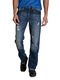

In [51]:
display_result(imgs)

In [42]:
def hybrid_scale(dense, sparse, alpha: float):
    """Hybrid vector scaling using a convex combination

    alpha * dense + (1 - alpha) * sparse

    Args:
        dense: Array of floats representing
        sparse: a dict of `indices` and `values`
        alpha: float between 0 and 1 where 0 == sparse only
               and 1 == dense only
    """
    if alpha < 0 or alpha > 1:
        raise ValueError("Alpha must be between 0 and 1")
    # scale sparse and dense vectors to create hybrid search vecs
    hsparse = {
        'indices': sparse['indices'],
        'values':  [v * (1 - alpha) for v in sparse['values']]
    }
    hdense = [v * alpha for v in dense]
    return hdense, hsparse

In [57]:
question = "dark blue french connection jeans for men"

# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

IndexError: ignored

In [ ]:
for x in result["matches"]:
    print(x["metadata"]['productDisplayName'])

In [ ]:
# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=1)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

In [ ]:
for x in result["matches"]:
    print(x["metadata"]['productDisplayName'])

In [ ]:
# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.05)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

In [ ]:
for x in result["matches"]:
    print(x["metadata"]['productDisplayName'])


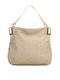

In [58]:
query = "small beige handbag for women"
# create sparse and dense vectors
sparse = bm25.encode_queries(query)
dense = model.encode(query).tolist()
# scale sparse and dense vectors - keyword search first
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0)
# search
result = index.query(
    top_k=1,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

In [ ]:
# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.05)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

In [ ]:
for x in result["matches"]:
    print(x["metadata"]['productDisplayName'])

In [ ]:
# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=1)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

In [ ]:
images[36254]

In [ ]:
query = "soft purple topwear"
# create the sparse vector
sparse = bm25.encode_queries(query)
# now create the dense vector using the image
dense = model.encode(images[36254]).tolist()
# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.3)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# use returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

In [ ]:
query = "soft purple topwear"
# create the sparse vector
sparse = bm25.encode_queries(query)
# now create the dense vector using the image
dense = model.encode(images[36254]).tolist()
# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.3)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True,
    filter={"baseColour": "Purple"}  # add to metadata filter
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

In [ ]:
images[36256]

In [ ]:
query = "soft green color topwear"
# create the sparse vector
sparse = bm25.encode_queries(query)
# now create the dense vector using the image
dense = model.encode(images[36256]).tolist()
# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.6)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True,
    filter={"baseColour": "Green"}  # add to metadata filter
)
# use returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

In [ ]:
pinecone.delete_index(index_name)